## Setup


In [1]:
import torch
import torchvision
import timm
import os
import matplotlib.pyplot as plt
import torch.nn as nn
from einops import rearrange
from tqdm import tqdm
from overcomplete.models import DinoV2, ViT, ResNet, ViT_Large, SigLIP
from torch.utils.data import DataLoader, TensorDataset
from overcomplete.sae import TopKSAE, train_sae
from overcomplete.visualization import (overlay_top_heatmaps, evidence_top_images, zoom_top_images, contour_top_image)
from torch.optim.lr_scheduler import SequentialLR, LinearLR, CosineAnnealingLR
import copy


from lib.data_handlers import Load_ImageNet100, Load_PACS, Load_ImageNet100Sketch
from lib.universal_trainer import train_usae
from lib.activation_generator import Load_activation_dataloader
from lib.eval import evaluate_models
from lib.visualizer import visualize_concepts
from lib.mlp import train_mlp, test_mlp, prune_weights, check_sparsity, plot_weight_histogram, plot_weight_histogram_before_after


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

c:\Users\sproj_ha\miniconda3\envs\interpretability\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## MLP

In [2]:
concepts = 768 * 8

sae = TopKSAE(768, nb_concepts=concepts, top_k=16, device="cuda")
sae.load_state_dict(torch.load("./models/ViT_MLP.pt")['ViT'])

vit_full = timm.create_model('vit_base_patch16_224', pretrained=True)

In [3]:
inet_trainloader, image_dataset = Load_ImageNet100(transform=None, batch_size=64, shuffle=True, dataset_allow=True, train=True)
inet_testloader = Load_ImageNet100(transform=None, batch_size=256, shuffle=True, dataset_allow=False, train=False)
sketch_trainloader, sketch_testloader = Load_ImageNet100Sketch(transform=None, batch_size=4, shuffle=True, train=False)


trainloaders = {
    "INET" : inet_trainloader,
    "Sketch": sketch_trainloader
}

testloaders = {
    "INET": inet_testloader,
    "Sketch": sketch_testloader
}


mlps = {}
optimizers = {}
schedulers = {}

for key in testloaders.keys():
    mlps[key] = nn.Linear(concepts, 100)
    optimizers[key] = torch.optim.Adam(params=mlps[key].parameters(), lr=1e-4)
    schedulers[key] = torch.optim.lr_scheduler.StepLR(optimizer=optimizers[key], gamma=0.5, step_size=1)

loss_fn = nn.CrossEntropyLoss()

epochs = {
    "INET": 5,
    "Sketch": 10
}

alpha = 1.0  # sparsity constraint

## Training

In [4]:
for domain in trainloaders.keys():

    print(f"====> Beginning Training for Domain: {domain}")
    
    for epoch in range(epochs[domain]):
        train_mlp(
            image_loader=trainloaders[domain],
            mlp=mlps[domain],
            optimizer=optimizers[domain],
            loss_fn=loss_fn,
            vit_full=vit_full,
            sae=sae,
            internal_map=image_dataset.class_to_idx,
            alpha=alpha,
            epoch=epoch
        )
        if schedulers[domain] is not None:
            schedulers[domain].step()

    torch.save(mlps[domain].state_dict(), f"./models/MLPs/mlp_vit_logits_alpha{alpha}_{domain}_{epochs[domain]}epochs.pth")
    print(f"Domain {domain} MLP Saved")

====> Beginning Training for Domain: INET


Epoch 0:   0%|          | 5/2032 [00:01<11:14,  3.01batch/s, loss=3774.4565]


KeyboardInterrupt: 

## Loading

In [4]:
for domain in trainloaders.keys():
    mlps[domain].load_state_dict(torch.load(f"./models/MLPs/mlp_vit_alpha1_{domain}_7ep.pth")) 

In [5]:
softmax_after = {}
softmax_before = {}
entropy_after = {}
entropy_before = {}

Pre-Sparse Accuracy

In [6]:
for domain in trainloaders.keys():
    print(f"====> Test Set for Domain: {domain}")
    _, _, softmax_before[domain], entropy_before[domain] = test_mlp(
            image_loader=testloaders[domain],
            mlp=mlps[domain],
            sae=sae,
            loss_fn=loss_fn,
            vit_full=vit_full,
            internal_map=image_dataset.class_to_idx
        )

====> Test Set for Domain: INET


Testing: 100%|██████████| 20/20 [00:40<00:00,  2.04s/batch, loss=0.3061]


Test finished. Avg loss: 0.2128, Accuracy: 95.67%
====> Test Set for Domain: Sketch


Testing: 100%|██████████| 128/128 [00:11<00:00, 11.27batch/s, loss=0.0000]

Test finished. Avg loss: 0.5640, Accuracy: 89.64%


Sparsification

In [7]:
sparse_mlps = {}
k = {"INET": 15, "Sketch": 2}
for key in trainloaders.keys():
    sparse_mlps[key] = prune_weights(copy.deepcopy(mlps[key]), k=k[key])
    sparsity, zeros = check_sparsity(sparse_mlps[key])
    
    # plot_weight_histogram_before_after(mlps[key], sparse_mlps[key], bins=(6144*100))
    
    print(f"{key} MLP Sparsity: {sparsity:.2f} | {(100*6144) - zeros}")


tensor(0.0005, device='cuda:0') tensor(3.3287e-05, device='cuda:0')
INET MLP Sparsity: 99.97 | 202
tensor(0.0003, device='cuda:0') tensor(0.0001, device='cuda:0')
Sketch MLP Sparsity: 99.85 | 931


Post-Sparse Accuracy

In [8]:
for domain in trainloaders.keys():
    print(f"====> Test Set for Domain: {domain}")
    _, _, softmax_after[domain], entropy_after[domain] = test_mlp(
            image_loader=testloaders[domain],
            mlp=sparse_mlps[domain],
            sae=sae,
            loss_fn=loss_fn,
            vit_full=vit_full,
            internal_map=image_dataset.class_to_idx
        )

====> Test Set for Domain: INET


Testing: 100%|██████████| 20/20 [00:52<00:00,  2.61s/batch, loss=0.2154]


Test finished. Avg loss: 0.2263, Accuracy: 95.86%
====> Test Set for Domain: Sketch


Testing: 100%|██████████| 128/128 [00:11<00:00, 10.81batch/s, loss=0.0000]

Test finished. Avg loss: 0.5865, Accuracy: 89.29%


Distribution Change

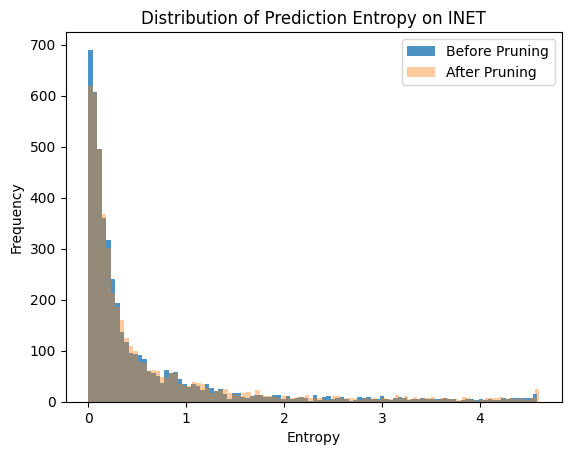

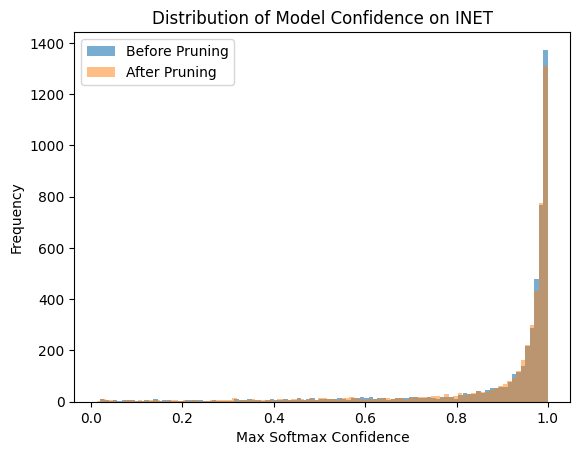

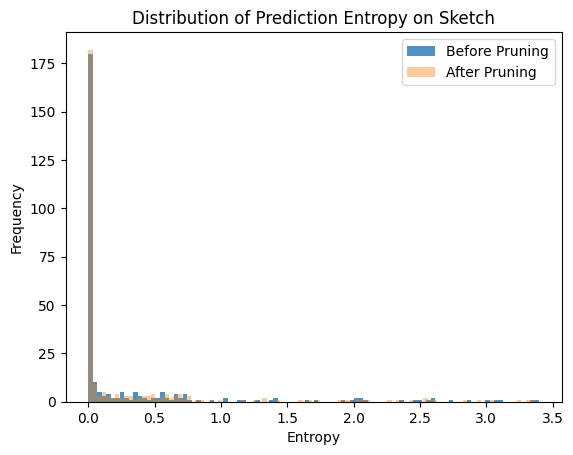

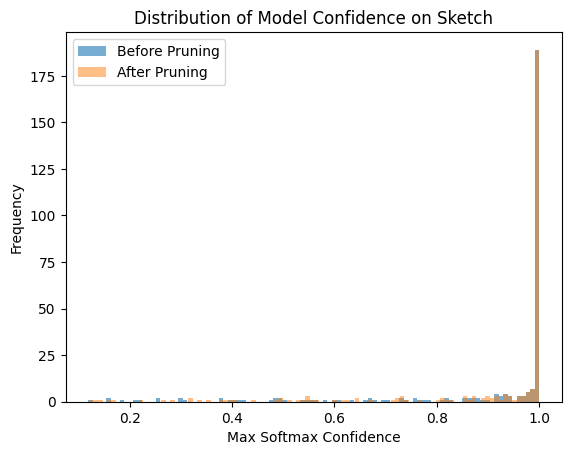

In [9]:
for domain in trainloaders.keys():

    plt.hist(entropy_before[domain].numpy(), bins=100, alpha=0.8, label="Before Pruning")
    plt.hist(entropy_after[domain].numpy(), bins=100, alpha=0.4, label="After Pruning")
    plt.xlabel("Entropy")
    plt.ylabel("Frequency")
    plt.legend()
    plt.title(f"Distribution of Prediction Entropy on {domain}")
    plt.show()

    conf_before = softmax_before[domain].max(dim=1).values
    conf_after = softmax_after[domain].max(dim=1).values

    plt.hist(conf_before.numpy(), bins=100, alpha=0.6, label="Before Pruning")
    plt.hist(conf_after.numpy(), bins=100, alpha=0.5, label="After Pruning")
    plt.xlabel("Max Softmax Confidence")
    plt.ylabel("Frequency")
    plt.legend()
    plt.title(f"Distribution of Model Confidence on {domain}")
    plt.show()


## Visualization 

In [ ]:
weights_ood = sparse_mlps["Sketch"].weight.detach().cpu()  # shape 100 x 6144
weights_iid = sparse_mlps["INET"].weight.detach().cpu() 

weights = {"OOD": weights_ood, "IID": weights_iid}

nonzero_indices = {}

for tag, weight in weights.items():
    nonzero_indices[tag] = []
    print(f"\n================ {tag} ==================")
    for class_idx in range(weight.shape[0]):
        class_weights = weight[class_idx]

        nonzero_idx = torch.nonzero(class_weights, as_tuple=True)[0]

        sorted_vals, sorted_idx = torch.sort(
            class_weights[nonzero_idx], descending=True
        )
        sorted_features = nonzero_idx[sorted_idx].tolist()
        sorted_strengths = sorted_vals.tolist()
        nonzero_indices[tag].append(set(sorted_features))

        print(f"\nClass {class_idx}: {len(sorted_features)} non-zero features (sorted by weight, positives first)")
        for f_idx, f_val in zip(sorted_features, sorted_strengths):
            print(f"    Feature {f_idx}: weight={f_val:.8f}")

In [ ]:
print("\n============== Common Non-Zero Indices ==============")
for class_idx in range(weights_ood.shape[0]):
    common = nonzero_indices["OOD"][class_idx].intersection(nonzero_indices["IID"][class_idx])

    # For strength display, take from OOD & IID separately
    ood_weights = weights["OOD"][class_idx]
    iid_weights = weights["IID"][class_idx]

    # Sort common features by average weight (favoring positive ones)
    common_sorted = sorted(
        list(common),
        key=lambda i: (ood_weights[i] + iid_weights[i]) / 2,
        reverse=True
    )

    print(f"\nClass {class_idx}: {len(common)} common non-zero features (sorted by avg weight)")
    for f_idx in common_sorted:
        print(
            f"    Feature {f_idx}: "
            f"OOD={ood_weights[f_idx]:.4f}, "
            f"IID={iid_weights[f_idx]:.4f}"
        )


In [ ]:
SAEs = {
    "ViT": sae
}

models = {
    "ViT": ViT(device="cuda")
}

inet_trainloader, _= Load_ImageNet100(transform=None, batch_size=256, shuffle=True, dataset_allow=True, train=True)

activations_dataloader = Load_activation_dataloader(
    models=models,
    image_dataloader=inet_trainloader,
    max_seq_len=196,
    save_dir=f"./activations/ViTMLP_INET",
    generate=True,
    rearrange_string='n t d -> (n t) d'
)

visualize_concepts(
    activation_loader=activations_dataloader,
    SAEs=SAEs,
    save_dir=f"./results/visualize2_VITMLP_INET",
    patch_width=14,
    num_concepts=concepts,
    n_images=4,
    abort_threshold=0.0,
)

In [ ]:
sketch_trainloader = Load_ImageNet100Sketch(transform=None, batch_size=250, shuffle=True, train=True)

activations_dataloader = Load_activation_dataloader(
    models=models,
    image_dataloader=sketch_trainloader,
    max_seq_len=196,
    save_dir=f"./activations/ViTMLP_sketch",
    generate=True,
    rearrange_string='n t d -> (n t) d'
)

visualize_concepts(
    activation_loader=activations_dataloader,
    SAEs=SAEs,
    save_dir=f"./results/visualize2_VITMLP_sketch",
    patch_width=14,
    num_concepts=concepts,
    n_images=8,
    abort_threshold=0.0,
)